In [1]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# import seaborn as sns
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
from ml.linear_models import KernelPerceptron, MulticlassKernelPerceptron
from ml.multiclass import OneVsOneClassifier
from ml.ensemble import RandomForestClassifier
from ml.svm import SVC

In [2]:
def plot_decision_boundary(x, y, clf, binary=True, ax=None):
    clf.fit(x, y)
    
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    x_to_pred = np.c_[xx.ravel(), yy.ravel()]
    z = clf.predict(x_to_pred)
    z = z.reshape(xx.shape)
    
    if binary:
        norm = TwoSlopeNorm(vcenter=0, vmin=z.min(), vmax=z.max())
        cm = ListedColormap(['#FF0000', '#0000FF'])
        if ax is None:
            plt.figure()
            plt.contourf(xx, yy, z, cmap='RdBu', norm=norm, alpha=0.8)
            plt.contourf(xx, yy, np.sign(z), cmap='RdBu', alpha=0.4)
            plt.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap=cm, edgecolors='k')
        else:
            ax.contourf(xx, yy, z, cmap='RdBu', norm=norm, alpha=0.8)
            ax.contourf(xx, yy, np.sign(z), cmap='RdBu', alpha=0.4)
            ax.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap=cm, edgecolors='k')
    else:
        plt.figure()
        plt.contourf(xx, yy, z, cmap='Spectral', alpha=0.8)
        plt.scatter(x[:, 0], x[:, 1], c=y, s=30, cmap='Spectral', edgecolors='k')

Change prediction rules to return certainty of classification.

In [3]:
class KernelPerceptron(KernelPerceptron):
    name = 'KernelPerceptron'
    
    def predict(self, x):
        kernel_matrix = self.kernel.compute_matrix(self.x, x)
        projection = self.alpha @ kernel_matrix
        return projection
    
class SVC(SVC):
    name = 'SVC'
    
    def predict(self, x):
            kernel_matrix = self.kernel.compute_matrix(self.support_vectors, x)
            projection = (self.dual_coef @ kernel_matrix) + self.intercept
            return projection
        
class RandomForestClassifier(RandomForestClassifier):
    name = 'RandomForestClassifier'
    
    def predict(self, x):
        n_samples, _ = x.shape
        y_preds = np.zeros((n_samples, self.n_estimators))
        for i, estimator in enumerate(self.estimators):
            y_preds[:, i] = estimator.predict(x)
        y_pred = np.zeros(n_samples)
        for i, yp in enumerate(y_preds):
            unique, counts = np.unique(yp, return_counts=True)
            probs = counts / counts.sum()
            idx = np.argmax(probs)
            y_pred[i] = probs[idx]*unique[idx]
        return y_pred

In [4]:
linearly_separable = make_classification(n_features=2, n_redundant=0,
                                         n_informative=2, random_state=1,
                                         n_clusters_per_class=1)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable
]

for i, dataset in enumerate(datasets):
    x, y = dataset
    x = StandardScaler().fit_transform(x)
    datasets[i] = (x, y)

## Kernels

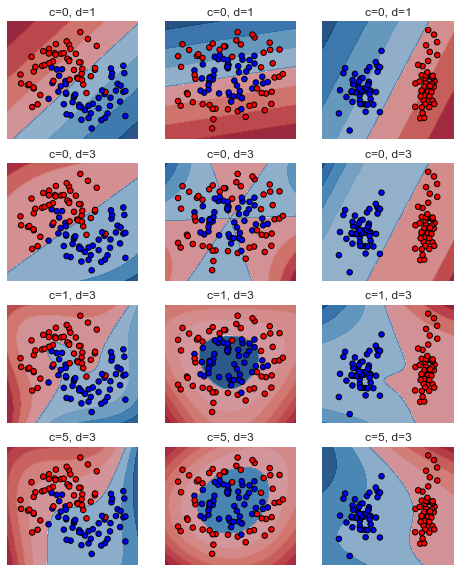

In [5]:
# Polynomial Kernel
classifiers = [
    KernelPerceptron(kernel='poly', kernel_params={'c':0, 'd':1}),
    KernelPerceptron(kernel='poly', kernel_params={'c':0, 'd':3}),
    KernelPerceptron(kernel='poly', kernel_params={'c':1, 'd':3}),
    KernelPerceptron(kernel='poly', kernel_params={'c':5, 'd':3}),
]

f, axes = plt.subplots(len(classifiers), len(datasets), figsize=(8, 10))
for axs, clf in zip(axes[:], classifiers):
    for ax, dataset in zip(axs, datasets):
        x, y = dataset
        ax.axis('off')
        c, d = clf.kernel.params['c'], clf.kernel.params['d']
        ax.set_title(f'c={c}, d={d}')
        plot_decision_boundary(x, y, clf, ax=ax)

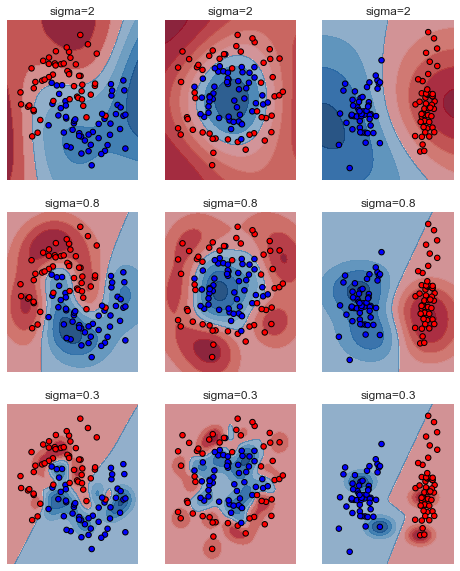

In [6]:
# RBF Kernel
classifiers = [
    KernelPerceptron(kernel='rbf', kernel_params={'sigma':2}),
    KernelPerceptron(kernel='rbf', kernel_params={'sigma':0.8}),
    KernelPerceptron(kernel='rbf', kernel_params={'sigma':0.3}),
]

f, axes = plt.subplots(len(classifiers), len(datasets), figsize=(8, 10))
for axs, clf in zip(axes[:], classifiers):
    for ax, dataset in zip(axs, datasets):
        x, y = dataset
        ax.axis('off')
        sigma = clf.kernel.params['sigma']
        ax.set_title(f'sigma={sigma}')
        clf.fit(x, y, epochs=6)
        plot_decision_boundary(x, y, clf, ax=ax)

## Algorithms

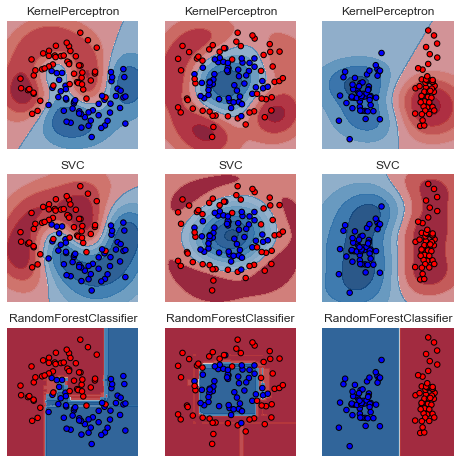

In [7]:
classifiers = [
    KernelPerceptron(kernel='rbf', kernel_params={'sigma':0.9}),
    SVC(kernel='rbf', kernel_params={'sigma':0.9}, C=1),
    RandomForestClassifier(n_estimators=10, max_depth=6, 
                           max_features=1, min_samples_split=4),
]

f, axes = plt.subplots(len(classifiers), len(datasets), figsize=(8, 8))
for axs, clf in zip(axes[:], classifiers):
    for ax, dataset in zip(axs, datasets):
        x, y = dataset
        ax.axis('off')
        ax.set_title(f'{clf.name}')
        clf.fit(x, y)
        plot_decision_boundary(x, y, clf, ax=ax)